# Fits different RL models for the learning task and compares results with Bayesian model

In [1]:
import os
import os.path as op
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy import stats, optimize
from pandas import DataFrame, Series
import random as rd
import scipy.io as sio
import scipy.stats
from scipy.optimize import minimize
import multiprocessing
import random
from matplotlib import cm
import math
import seaborn as sns
from ipyparallel import Client

#R stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex')

%matplotlib inline
sns.set_context("paper")

In [3]:
rc = Client()

# Load and Parse Data

In [4]:
sub_list = ['23','24','25','26','27','28','30','31','32','35','36','37','39','40']
home_dir = '/Users/ianballard/Dropbox/rule_learning/'
cond = map(str,range(1,7))
key_map = {30:1,31:0,0:np.NaN,36:np.NaN}
cond_map = {'1':'aandb','2':'aandborc','3':'aorb','4':'a','5':'axorb','6':'aorbandc'}
cond_map2 = {'1':'A and B','2':'(A and B) or C','3':'A or B','4':'A','5':'A xor B','6':'(A or B) and C'}
df = {'hits':[],'sub':[],'condition':[],'true':[],'trial':[],'a':[],'b':[],'c':[],'rt':[]}
correct_answers =  os.path.abspath('correct_answers.mat')
correct_answers = scipy.io.loadmat(correct_answers)

for cond in cond:
    for sub in sub_list:        
        f = os.path.abspath('../behav_data/' + sub + '_rule_learning_' + cond + '.mat')
        f = scipy.io.loadmat(f)
        hits = f['subject_responses'][:,2]
        rt = f['subject_responses'][:,6]*1000
        correct = correct_answers['correct_answers_' + cond_map[cond]].flatten()
        order = f['stim_order']

        df['true'].extend(correct*-1 + 1)
        df['hits'].extend(hits)
        df['rt'].extend(rt)
        df['sub'].extend([sub]*len(hits))
        df['condition'].extend([cond_map2[cond]]*len(hits))
        df['trial'].extend(range(len(hits)))
        df['a'].extend(order[:,0] *-1 + 2)
        df['b'].extend(order[:,1] *-1 + 2)
        df['c'].extend(order[:,2] *-1 + 2)
        
df = pd.DataFrame(df)

#fill in what response must have been
true = df['true'].values.astype(bool)
hit = df['hits'].values
resp = []
for n,t in enumerate(true):
    if hit[n]:
        resp.append(t)
    else:
        resp.append(not t)
resp = np.array(resp).astype(int)
df['resp'] = resp
df['type'] = 'subject'
df.to_csv(op.abspath('../behavioral_data_rt.csv'),index = False)

In [19]:
model_accuracy =  os.path.abspath('model_accuracy.mat')
model_accuracy = scipy.io.loadmat(model_accuracy)
model_accuracy = model_accuracy['model_accuracy']
df2 = {}
df2['hits'] = list(df['hits'].values) + list(model_accuracy.ravel(order='F'))
df2['sub'] =  list(df['sub'].values) + ['model'] * 120
df2['trial'] = list(df['trial'].values) + range(0,20)*6
df2['condition'] = list(df['condition'].values) + list(np.repeat(['A and B','(A and B) or C','A or B','A','A xor B','(A or B) and C'],20))
df2['type'] = list(df['type'].values) + ['model'] * 120

df2 = pd.DataFrame(df2)
df2 = df2.sort_values(by = ['type','condition','sub','trial'])
 
df2.to_csv(op.abspath('../behavioral_data.csv'),index = False)
bayes_predictions = df2[df2['type'] == 'model']

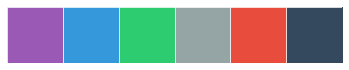

In [20]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#95a5a6", "#e74c3c", "#34495e"]
sns.palplot(sns.color_palette(flatui))

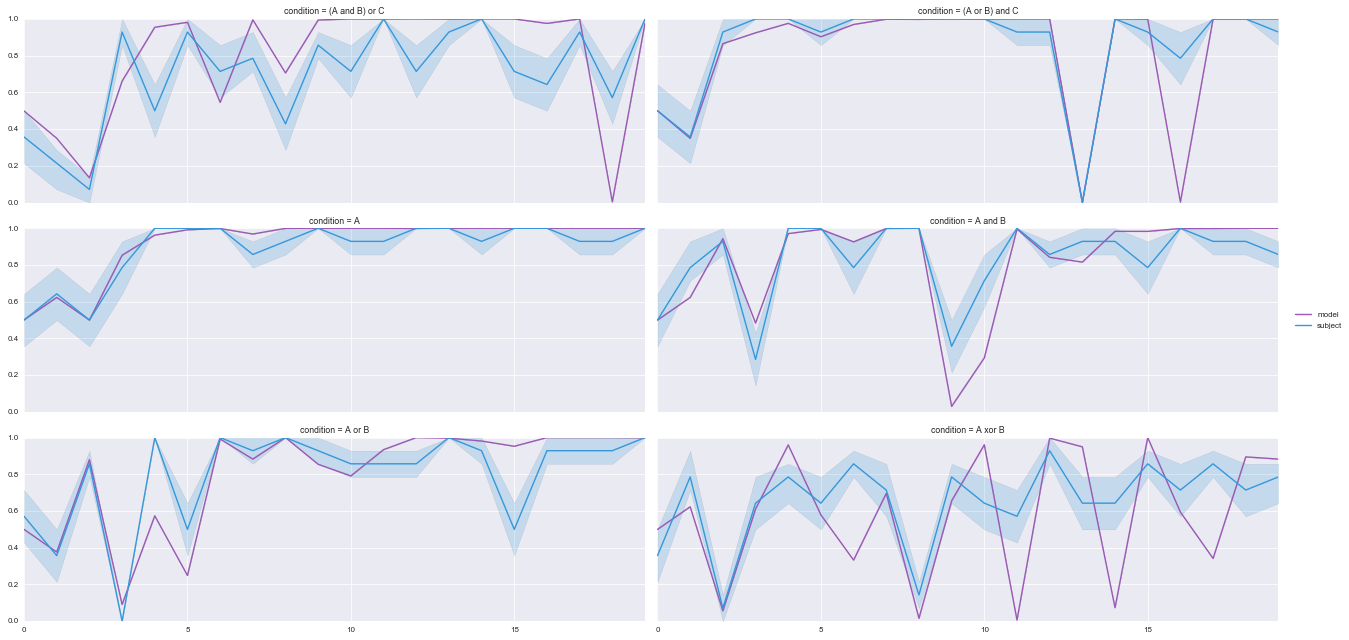

In [7]:
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(df2, col='condition',col_wrap = 2, aspect = 3)
g.map_dataframe(sns.tsplot, time="trial", unit="sub",
                value="hits", condition = 'type',color = sns.color_palette(flatui)).add_legend()

plt.savefig(home_dir + '/figures/model_fits.png',dpi=600)

# RL functions

In [8]:
#take the feature values and return a state representation
def state_to_features(state, state_rep):
    if state_rep == 'naive': #one feature per state
        return [tuple(state)]
    
    if state_rep == 'feature': 
        features = []
        for n,s in enumerate(state):
            features.append(str(n) + '_'  + str(s))
        return features
    
    if state_rep == 'exhaustive': #all possible combinations of features
        features = [tuple(state)]
        for n1,s1 in enumerate(state):
            features.append(str(n1) + '_'  + str(s1))
            for n2,s2 in enumerate(state):
                if n1 < n2:
                    features.append( str(n1) + '_'  + str(s1) + '_' +  str(n2) + '_'  + str(s2) )
        return features

In [9]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q * m), Q)
    probs = probs / np.sum(probs)
    return probs

In [10]:
#return rescorla-wagner update
def update_Q(rew,action,Q,alpha):
    PE = rew - Q[action]
    delta = alpha * (rew - Q[action])
    return delta

In [11]:
def get_LL(alpha, m, gamma, mix, states, resp, outcomes, true, bayes_cond_predictions, state_rep, return_LL):

    Q_values = {}
    associabilities = {}
    LL = 0
    deltas = []
    probs = []
    for n,a in enumerate(resp):
        #get q values for features
        features = state_to_features(states[:,n], state_rep)
        Q_state = np.array([0,0])
        for feat in features:
            if feat in Q_values.keys():
                Q = Q_values[feat]
            else: #initialize Q
                Q = np.array([0.0,0.0])
                Q_values[feat] = Q
                associabilities[feat] = [1.0]
            Q_state = Q_state + Q #sum up features

        #get choice probability
        p = get_prob(Q_state,m)[a]
        
        #blend with Bayesian predictions
        hit = (outcomes[n] + 1)/2 #-1/1 coding is good for RL, 1/0 coding is good for bernoulli
        bayes_p = scipy.stats.bernoulli.pmf(hit, bayes_cond_predictions[n])   
        p = (1-mix)*p + mix*bayes_p
        probs.append(p)    
        if p < 1e-200 or np.isnan(p):
            update = np.log(1e-200)
        else:
            update = np.log(p)
        LL += update
        
        #update weights (with the state expectation used in PE)
        delta_Q = update_Q(outcomes[n],a,Q_state,alpha) #get updated Q
        deltas.append(delta_Q)
        for feat in features:
            Q = list(Q_values[feat])
            Q[a] = Q[a] + delta_Q * associabilities[feat][-1]
            Q[1-a] = Q[1-a] - delta_Q * associabilities[feat][-1]#learning is symmetric
            Q_values[feat] = np.array(Q) 
        
            #Update associabilities
            new_assoc = abs(delta_Q)*gamma + (1 - gamma)*associabilities[feat][-1]
            associabilities[feat].append(new_assoc)
    if return_LL:
        return LL
    else:
        return deltas, probs

In [12]:
def parse_params(params,assoc,bayes_mixture):
    alpha = params[0]
    m = params[1]
    mix = 0
    gamma = 0
    if assoc:
        gamma = params[2]
        if bayes_mixture:
            mix = params[3]
    elif bayes_mixture:
        mix = params[2]
        
    return alpha, m, gamma, mix

In [13]:
#compute the likelihood for run. Useful for rule-by-rule comparisone
def get_test_LL(params,test_df,state_rep,assoc,bayes_mixture):
    
    alpha, m, gamma, mix = parse_params(params,assoc,bayes_mixture)

    #get info for RL
    states = np.array([test_df['a'].values,test_df['b'].values,test_df['c'].values])
    resp = test_df['resp'].values
    outcomes = test_df['hits'].values *2 -1
    true = test_df['true'].values *2 -1

    #get info for bayes
    test_cond = test_df['condition'].values[0]
    bayes_cond_predictions = bayes_predictions[bayes_predictions['condition'] == test_cond]['hits'].values
    
    pe,probs = get_LL(alpha, m, gamma, mix,
                      states, resp, outcomes, true, bayes_cond_predictions,
                      state_rep, False)
    
    return np.mean(probs)

In [14]:
def get_train_LL(params,train_df,state_rep,assoc,bayes_mixture):
    
    alpha, m, gamma, mix = parse_params(params,assoc,bayes_mixture)

    LL = 0
    #loop through runs
    for fit_cond in set(train_df['condition'].values):
        c = train_df[train_df['condition'] == fit_cond]
        states = np.array([c['a'].values,c['b'].values,c['c'].values])
        resp = c['resp'].values
        outcomes = c['hits'].values *2 -1
        true = c['true'].values *2 -1

        #get info for bayes
        bayes_cond_predictions = bayes_predictions[bayes_predictions['condition'] == fit_cond]['hits'].values
        LL += get_LL(alpha, m, gamma, mix,
                      states, resp, outcomes, true, bayes_cond_predictions,
                      state_rep, True)

    LL *= -1 #minimize
    return LL

# Run RL fitting

In [16]:
def fit_model(in_tuple):
    sub, state_rep, assoc, bayes_mixture = in_tuple
    out_f = op.abspath('../model_fitting/' + '_'.join([sub,'assoc_' + str(assoc),state_rep,'mix_' + str(bayes_mixture)]) + '.csv')

    if not op.exists(out_f):
    
        sub_results = {'sub':[],'test_cond':[],
                       'alpha':[],'m':[],'gamma':[],'epsilon':[],
                       'fit_LL':[], 'model':[],'assoc':[],'bayes_mixture':[],'test_LL':[]}

        sub_data = df[df['sub'] == sub]

        conds = set(sub_data['condition'])
        for cond in conds:

            #fit parameters to other conditions
            train_df = sub_data[sub_data['condition'] != cond]
            if assoc:
                if bayes_mixture:
                    params = [.2,2,0,0]
                    bounds =((0, 1), (0.01, 20), (0, 1), (0, 1))
                else:
                    params = [.2,2,0]
                    bounds =((0, 1), (0.01, 20), (0, 1))
            else:
                if bayes_mixture:
                    params = [.2,2,0]
                    bounds =((0, 1), (0.01, 20), (0, 1))                
                else:
                    params = [.2,2]
                    bounds =((0, 1), (0.01, 20))

            res = scipy.optimize.minimize(get_train_LL, 
                                          params, 
                                          args=(train_df, state_rep, assoc, bayes_mixture),
                                          options={'disp': True},
                                          bounds = bounds)

            #predict the likelihood of the held out condition
            test_df = sub_data[sub_data['condition'] == cond]
            test_LL = get_test_LL(res.x, test_df, state_rep, assoc, bayes_mixture)

            #compile results
            sub_results['sub'].append(sub)
            sub_results['test_cond'].append(cond)
            sub_results['alpha'].append(res.x[0])
            sub_results['m'].append(res.x[1])
            sub_results['fit_LL'].append(res.fun*-1)
            sub_results['model'].append(state_rep)
            sub_results['assoc'].append(assoc)
            sub_results['bayes_mixture'].append(bayes_mixture)
            sub_results['test_LL'].append(test_LL)
            if assoc:
                sub_results['gamma'].append(res.x[2])
                if bayes_mixture:
                    sub_results['epsilon'].append(res.x[3])
                else:
                    sub_results['epsilon'].append(0)
            else:
                sub_results['gamma'].append(0)            
                if bayes_mixture:
                    sub_results['epsilon'].append(res.x[2])
                else:
                    sub_results['epsilon'].append(0)

        sub_results = pd.DataFrame(sub_results)
        sub_results.to_csv(out_f,index = False)

In [17]:
states = ['naive','feature','exhaustive']
in_tuples = []
for sub in sub_list:
    for assoc in [True,False]:
        for state_rep in states:
            for bayes_mixture in [True,False]:
                in_tuples.append((sub,state_rep,assoc,bayes_mixture))

In [23]:
# dview = rc[0:3]
# dview.block = True

# dview.push(dict(get_train_LL = get_train_LL,
#                get_test_LL = get_test_LL,
#                df = df,
#                bayes_predictions = bayes_predictions,
#                parse_params = parse_params,
#                state_to_features = state_to_features,
#                update_Q = update_Q,
#                get_LL = get_LL,
#                get_prob = get_prob))
# dview.execute("import numpy as np")
# dview.execute("import os.path as op")
# dview.execute("import pandas as pd")
# with dview.sync_imports():
#     import os
#     import scipy
#     import scipy.stats
# dview.map_sync(fit_model,in_tuples)

In [152]:
results_df = []
for in_tuple in in_tuples:
    sub, state_rep, assoc, bayes_mixture = in_tuple
    out_f = op.abspath('../model_fitting/' + '_'.join([sub,'assoc_' + str(assoc),state_rep,'mix_' + str(bayes_mixture)]) + '.csv')
    sub_results = pd.read_csv(out_f)
    results_df.append(sub_results.copy())
results_df = pd.concat(results_df)

In [153]:
assoc_map = {True:'PH',False:'std','':''}
bayes_map = {True:'Bayes',False:'','':''}

results_df['model_id'] = [x + '_' + assoc_map[y] + '_' + bayes_map[z] for x,y,z in zip(results_df['model'],
                                                                                         results_df['assoc'],
                                                                                         results_df['bayes_mixture'])]

In [210]:
results_df.to_csv(home_dir + 'predictie_LL_results.csv',index = False)
results_df.groupby('model_id').mean()

,alpha,assoc,bayes_mixture,epsilon,fit_LL,gamma,m,sub,test_LL
model_id,,,,,,,,,
bayes,NaN,NaN,False,NaN,-42.231904,NaN,NaN,30.928571,0.727649
exhaustive_PH_,0.162100,1,False,NaN,-40.148526,0.307822,1.911619,30.928571,0.729105
exhaustive_PH_Bayes,0.197770,1,True,NaN,-37.311640,0.481773,4.780500,30.928571,0.744151
exhaustive_std_,0.128702,0,False,NaN,-41.202076,0.000000,1.889800,30.928571,0.723554
exhaustive_std_Bayes,0.156218,0,True,NaN,-38.272941,0.000000,4.671373,30.928571,0.737927
feature_PH_,0.249843,1,False,NaN,-50.207532,0.231909,1.655481,30.928571,0.651964
feature_PH_Bayes,0.080600,1,True,NaN,-41.269157,0.324170,9.334987,30.928571,0.728231
feature_std_,0.171141,0,False,NaN,-51.645619,0.000000,1.493674,30.928571,0.642339
feature_std_Bayes,0.132250,0,True,NaN,-41.498047,0.000000,5.479743,30.928571,0.727841


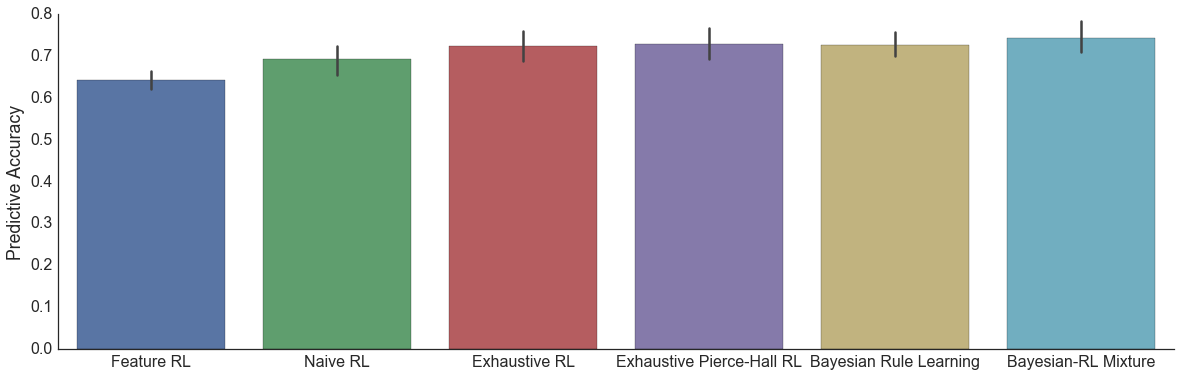

In [206]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (20, 6)})
sns.set_style("white")
fig_df = results_df.groupby(['sub','model_id']).mean().reset_index().copy()

#drop other conditions
cond_order = ['feature_std_','naive_std_','exhaustive_std_','exhaustive_PH_','bayes','exhaustive_PH_Bayes']
for m in set(fig_df['model_id']):
    if m not in cond_order:
        fig_df = fig_df[fig_df['model_id'] != m]

#make pretty
cond_names_figure = {'bayes':'Bayesian Rule Learning',
                    'feature_std_': 'Feature RL',
                     'naive_std_':'Naive RL',
                     'exhaustive_std_': 'Exhaustive RL',
                     'exhaustive_PH_': 'Exhaustive Pierce-Hall RL',
                     'exhaustive_PH_Bayes': "Bayesian-RL Mixture"}
fig_df['model_names'] = [cond_names_figure[x] for x in fig_df['model_id']]
cond_order = [cond_names_figure[x] for x in cond_order]

ax = sns.barplot(x="model_names", y="test_LL", order = cond_order, data=fig_df)
              
sns.despine()
plt.ylabel('Predictive Accuracy')
plt.xlabel('')
plt.savefig('../figures/revision/predictive_likelihoods.png',dpi=600)

In [208]:
a = results_df.set_index('model_id').loc['exhaustive_PH_Bayes'].groupby('sub').mean()['test_LL'].values
b = results_df.set_index('model_id').loc['exhaustive_std_'].groupby('sub').mean()['test_LL'].values

print scipy.stats.ttest_rel(a, b)
print np.mean(a),np.mean(b)

Ttest_relResult(statistic=3.6498958826639103, pvalue=0.0029379137763553193)
0.744151416997 0.723553985445


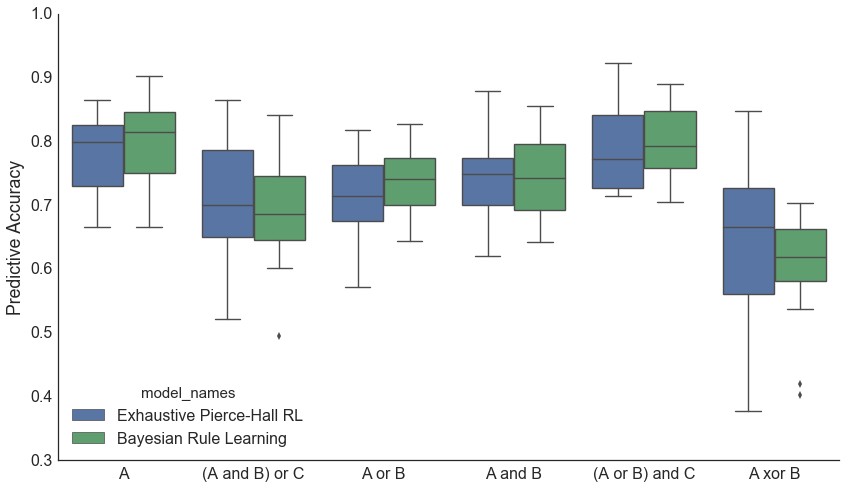

In [211]:
plt.figure(figsize=(14, 8))
fig_df = results_df.copy()

cond_order = ['bayes','exhaustive_PH_']
for m in set(fig_df['model_id']):
    if m not in cond_order:
        fig_df = fig_df[fig_df['model_id'] != m]
        

#make pretty
cond_names_figure = {'bayes':'Bayesian Rule Learning',
                    'feature_std_': 'Feature RL',
                     'naive_std_':'Naive RL',
                     'exhaustive_std_': 'Exhaustive RL',
                     'exhaustive_PH_': 'Exhaustive Pierce-Hall RL',
                     'exhaustive_PH_Bayes': "Bayesian-RL Mixture"}
fig_df['model_names'] = [cond_names_figure[x] for x in fig_df['model_id']]
cond_order = [cond_names_figure[x] for x in cond_order]

sns.boxplot(x="test_cond", y="test_LL",hue = 'model_names', data=fig_df)
sns.despine()
plt.ylabel('Predictive Accuracy')
plt.xlabel('')
plt.savefig('../figures/revision/rule_by_rule.png',dpi=600)

In [232]:
cond_df = pd.pivot_table(fig_df, values='test_LL', index=['test_cond', 'sub'],
                   columns=['model_id'])
for cond in set(cond_df.index.get_level_values(0)):
    t,p = scipy.stats.ttest_rel(cond_df.loc[cond,'bayes'],
                                cond_df.loc[cond,'exhaustive_PH_'])
    print cond, t, p

A 4.69570776387 0.000418448583571
(A and B) or C -2.07221432881 0.0586942159517
A or B 1.9055314643 0.0790659731631
A and B 0.341069060939 0.738500997944
(A or B) and C 0.871398040913 0.399343926506
A xor B -2.13013393821 0.0528365847676


# Fit noise parameter of the Bayesian model

In [146]:
def get_train_LL_bayes(params,train_df):
    epsilon = params[0]

    LL = 0
    #loop through runs
    for fit_cond in set(train_df['condition'].values):
        c = train_df[train_df['condition'] == fit_cond]
        outcomes = c['hits'].values
        
        #get bayesian model predictions
        model_cond = bayes_predictions[bayes_predictions['condition'] == fit_cond]
        model_cond = model_cond['hits'].values

        for n,x in enumerate(outcomes):
            m_prob = (1-epsilon)*.5 + model_cond[n]*epsilon
            p = scipy.stats.bernoulli.pmf(x,m_prob)
            if p < 1e-200 or np.isnan(p):
                p = 1e-200            
            LL += np.log(p)
    
    LL *= -1 #minimize
    return LL

In [200]:
#compute the likelihood for run. Useful for rule-by-rule comparisone
def get_test_LL_bayes(params,test_df):
    
    epsilon = params[0]
    
    outcomes = test_df['hits'].values
    test_cond = test_df['condition'].values[0]
    model_cond = bayes_predictions[bayes_predictions['condition'] == test_cond]
    model_cond = model_cond['hits'].values
    
    prob = 0
    for n,x in enumerate(outcomes):
        m_prob = (1-epsilon)*.5 + model_cond[n]*epsilon
        prob += scipy.stats.bernoulli.pmf(x, m_prob)         
    
    mean_prob = prob/len(outcomes)
    return mean_prob

In [201]:
def fit_model_bayes(sub):
    sub_results = {'sub':[],'test_cond':[],'alpha':[],'m':[],'gamma':[],'fit_LL':[],
                   'model':[],'assoc':[],'test_LL':[],'epsilon':[]}

    sub_data = df[df['sub'] == sub]

    conds = set(sub_data['condition'])
    for cond in conds:

        #fit parameters to other conditions
        train_df = sub_data[sub_data['condition'] != cond]
        params = [.85]
        bounds = [(0, 1)]
        
        res = scipy.optimize.minimize(get_train_LL_bayes, 
                                      params, 
                                      args=(train_df),
                                      options={'disp': True},
                                      bounds = bounds)

        #predict the likelihood of the held out condition
        test_df = sub_data[sub_data['condition'] == cond]
        test_LL = get_test_LL_bayes(res.x, test_df)

        #compile results
        sub_results['sub'].append(sub)
        sub_results['test_cond'].append(cond)
        sub_results['epsilon'].append(res.x[0])
        sub_results['fit_LL'].append(res.fun*-1)
        sub_results['model'].append('bayes')
        sub_results['assoc'].append(None)
        sub_results['test_LL'].append(test_LL)
        sub_results['alpha'].append(np.NaN)
        sub_results['m'].append(np.NaN)
        sub_results['gamma'].append(np.NaN)

    sub_results = pd.DataFrame(sub_results)
    out_f = op.abspath('../model_fitting/' + '_'.join([sub,'bayes']) + '.csv')
    sub_results.to_csv(out_f,index = False)

In [202]:
dview = rc[0:3]
dview.block = True

dview.push(dict(get_train_LL_bayes = get_train_LL_bayes,
                get_test_LL_bayes = get_test_LL_bayes,
                df = df,
                bayes_predictions = bayes_predictions))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import scipy
    import scipy.stats
dview.map_sync(fit_model_bayes,sub_list)

importing os on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [203]:
bayes_results = []
for sub in sub_list:
    out_f = op.abspath('../model_fitting/' + '_'.join([sub,'bayes']) + '.csv')
    sub_results = pd.read_csv(out_f)
    bayes_results.append(sub_results.copy())
bayes_results = pd.concat(bayes_results)
bayes_results['model_id'] = 'bayes'
results_df['epsilon'] = np.NaN
bayes_results['bayes_mixture'] = False

In [156]:
results_df = pd.concat([results_df,bayes_results])

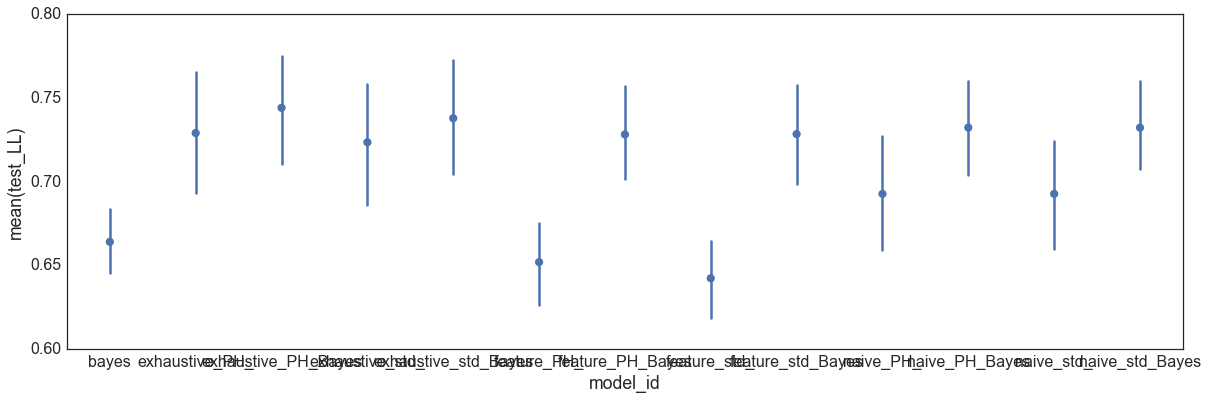

In [112]:
fig_df = results_df.groupby(['sub','model_id']).mean().reset_index()
sns.pointplot(x="model_id", y="test_LL", data=fig_df, join=False)

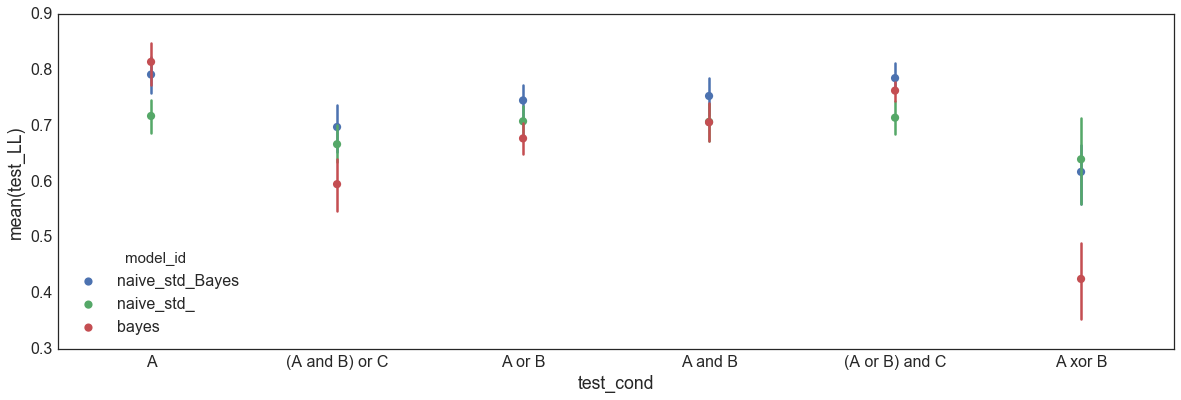

In [113]:
fig_df = results_df[results_df['assoc'] != True]
fig_df = fig_df[fig_df['model'] != 'feature']

fig_df = fig_df[fig_df['model'] != 'exhaustive']
sns.pointplot(x="test_cond", y="test_LL",hue = 'model_id', data=fig_df, join=False)

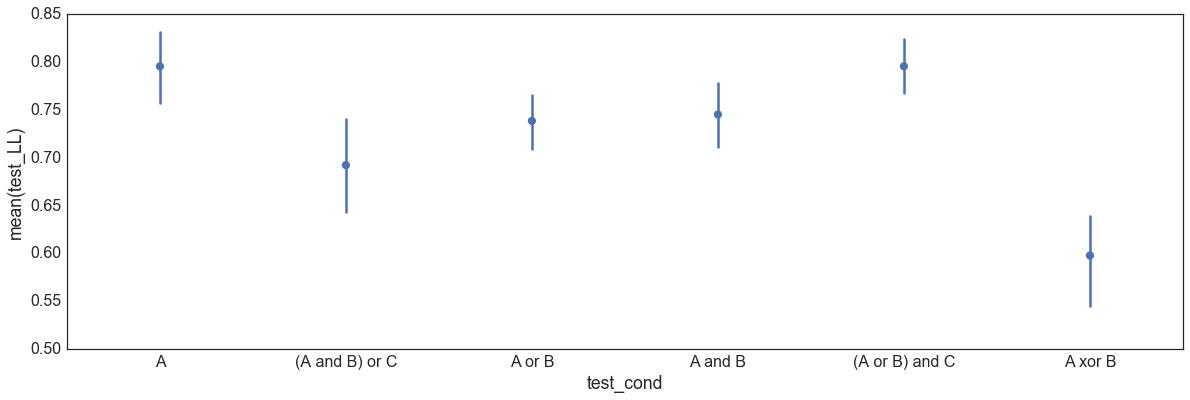

In [204]:
sns.pointplot(x="test_cond", y="test_LL", data=bayes_results, join=False)

In [193]:
bayes_results.mean()

alpha                  NaN
assoc                  NaN
epsilon           0.804865
fit_LL          -42.231904
gamma                  NaN
m                      NaN
sub              30.928571
test_LL           0.727649
bayes_mixture     0.000000
dtype: float64

In [199]:
bayes_results

,alpha,assoc,epsilon,fit_LL,gamma,m,model,sub,test_LL,test_cond,model_id,bayes_mixture
0,NaN,NaN,0.699684,-51.279700,NaN,NaN,bayes,23,0.701991,A,bayes,False
1,NaN,NaN,0.660763,-52.996957,NaN,NaN,bayes,23,0.734023,(A and B) or C,bayes,False
2,NaN,NaN,0.695078,-50.990950,NaN,NaN,bayes,23,0.676254,A or B,bayes,False
3,NaN,NaN,0.662111,-52.892936,NaN,NaN,bayes,23,0.730146,A and B,bayes,False
4,NaN,NaN,0.656059,-53.602165,NaN,NaN,bayes,23,0.765562,(A or B) and C,bayes,False
5,NaN,NaN,0.703920,-49.354931,NaN,NaN,bayes,23,0.603855,A xor B,bayes,False
0,NaN,NaN,0.740600,-48.765355,NaN,NaN,bayes,24,0.856904,A,bayes,False
1,NaN,NaN,0.891942,-37.790446,NaN,NaN,bayes,24,0.631110,(A and B) or C,bayes,False
2,NaN,NaN,0.784522,-44.610699,NaN,NaN,bayes,24,0.739373,A or B,bayes,False
3,NaN,NaN,0.779032,-45.645810,NaN,NaN,bayes,24,0.771467,A and B,bayes,False
